# **Kelompok 12 2023A**
* Layyinatul Qolbiyah       (23031554025)
* Nailah Masruroh           (23031554100)
* Yulia Eka Restania        (23031554199)
* Novia Djoend Lestari      (23031554220)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer, Dropout, Dense
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/datmin project/DataEmas.csv")
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,30/05/2025,"3.330,10","3.354,60","3.361,40","3.310,00","0,19K","-0,85%"
1,29/05/2025,"3.358,70","3.328,60","3.368,10","3.290,00","0,32K","1,09%"
2,28/05/2025,"3.322,40","3.328,60","3.352,00","3.301,00","184,89K","-0,18%"
3,27/05/2025,"3.328,30","3.385,00","3.385,00","3.311,40","132,78K","-1,37%"
4,26/05/2025,"3.374,47","3.370,17","3.384,00","3.352,50","29,79K","0,12%"
...,...,...,...,...,...,...,...
3924,08/01/2010,"1.138,90","1.131,50","1.140,00","1.119,50","212,62K","0,46%"
3925,07/01/2010,"1.133,70","1.139,00","1.139,50","1.128,70","121,15K","-0,25%"
3926,06/01/2010,"1.136,50","1.118,50","1.141,00","1.116,80","176,90K","1,59%"
3927,05/01/2010,"1.118,70","1.122,00","1.129,60","1.115,50","156,41K","0,04%"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tanggal     3929 non-null   object
 1   Terakhir    3929 non-null   object
 2   Pembukaan   3929 non-null   object
 3   Tertinggi   3929 non-null   object
 4   Terendah    3929 non-null   object
 5   Vol.        3926 non-null   object
 6   Perubahan%  3929 non-null   object
dtypes: object(7)
memory usage: 215.0+ KB


In [ ]:
df.isnull().sum()

,0
Tanggal,0
Terakhir,0
Pembukaan,0
Tertinggi,0
Terendah,0
Vol.,3
Perubahan%,0


In [ ]:
# Rename kolom
df = df.rename(columns={
    'Tanggal': 'Date',
    'Terakhir': 'Close',
    'Pembukaan': 'Open',
    'Tertinggi': 'High',
    'Terendah': 'Low',
    'Vol.': 'Volume',
    'Perubahan%': 'Change%'
})

In [ ]:
df = df.dropna().copy()

In [ ]:
# Konversi kolom 'Date' ke datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

In [ ]:
# Hilangkan karakter non-angka dari kolom harga
cols_harga = ['Close', 'Open', 'High', 'Low']
for col in cols_harga:
    df[col] = df[col].str.replace('.', '', regex=False)
    df[col] = df[col].str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# Tangani kolom Volume
def parse_volume(vol):
    try:
        if pd.isna(vol):
            return None
        vol = vol.replace(',', '.')  # ubah koma jadi titik desimal
        if 'K' in vol:
            return float(vol.replace('K', '')) * 1_000
        elif 'M' in vol:
            return float(vol.replace('M', '')) * 1_000_000
        else:
            return float(vol)
    except:
        return None

df['Volume'] = df['Volume'].apply(parse_volume)

In [ ]:
# Bersihkan kolom 'Change%' dan konversi ke float
df['Change%'] = df['Change%'].str.replace('%', '', regex=False)
df['Change%'] = df['Change%'].str.replace(',', '.', regex=False)
df['Change%'] = pd.to_numeric(df['Change%'], errors='coerce')

In [ ]:
# Membuat kolom baru bernama Volatility (Seberapa besar pergerakan harga dalam 1 hari)
df['Volatility'] = df['High'] - df['Low']
df.reset_index(drop=True, inplace=True)

In [ ]:
# Cek data setelah preprocessing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3926 entries, 0 to 3925
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        3926 non-null   datetime64[ns]
 1   Close       3926 non-null   float64       
 2   Open        3926 non-null   float64       
 3   High        3926 non-null   float64       
 4   Low         3926 non-null   float64       
 5   Volume      3926 non-null   float64       
 6   Change%     3926 non-null   float64       
 7   Volatility  3926 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 245.5 KB


# **EDA**

In [ ]:
df[['Close', 'Open', 'High', 'Low', 'Volume', 'Change%', 'Volatility']].describe()

,Close,Open,High,Low,Volume,Change%,Volatility
count,3926.000000,3926.000000,3926.000000,3926.000000,3926.000000,3926.000000,3926.000000
mean,1588.080958,1588.161556,1599.524024,1576.208263,137306.301579,0.033709,23.315762
std,424.685738,424.486270,428.476744,420.610500,112233.265251,1.011683,15.721466
min,1049.600000,1051.500000,1062.700000,1044.500000,120.000000,-9.340000,2.300000
25%,1267.225000,1266.750000,1274.100000,1258.700000,5012.500000,-0.440000,13.400000
50%,1480.250000,1479.600000,1492.050000,1471.650000,141890.000000,0.030000,19.300000
75%,1805.475000,1806.775000,1817.100000,1791.875000,204065.000000,0.570000,28.500000
max,3425.300000,3448.100000,3509.900000,3379.100000,816530.000000,5.950000,159.900000


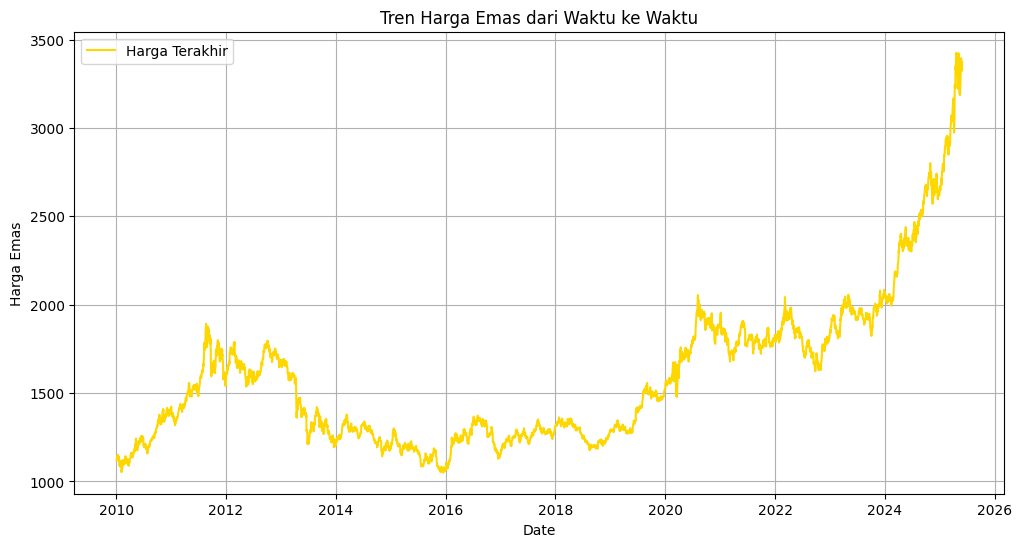

In [ ]:
# Tren harga emas
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Harga Terakhir', color='gold')
plt.xlabel('Date')
plt.ylabel('Harga Emas')
plt.title('Tren Harga Emas dari Waktu ke Waktu')
plt.legend()
plt.grid(True)
plt.show()

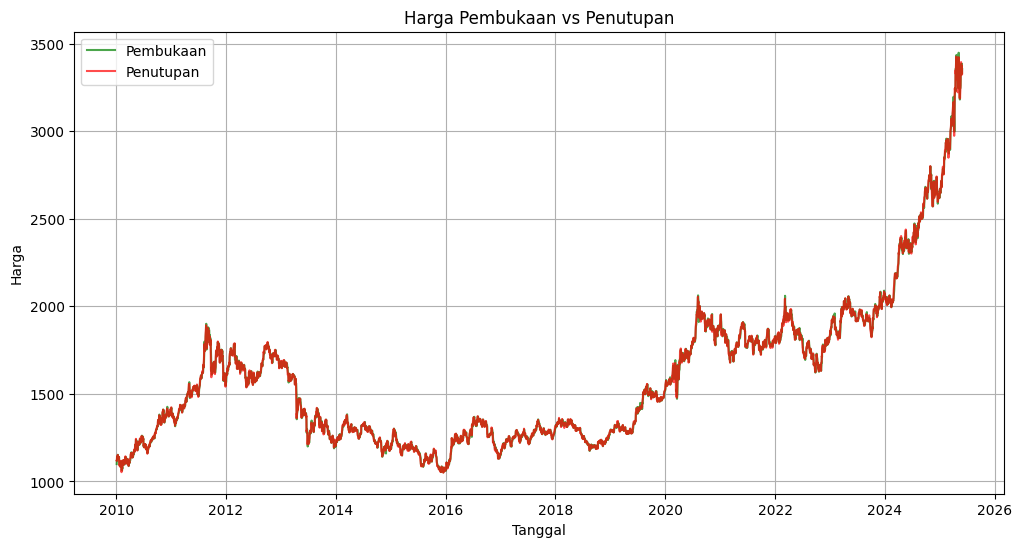

In [ ]:
# Harga pembukaan vs penutupan
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'], label='Pembukaan', alpha=0.7, color='green')
plt.plot(df['Date'], df['Close'], label='Penutupan', alpha=0.7, color='red')
plt.title('Harga Pembukaan vs Penutupan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

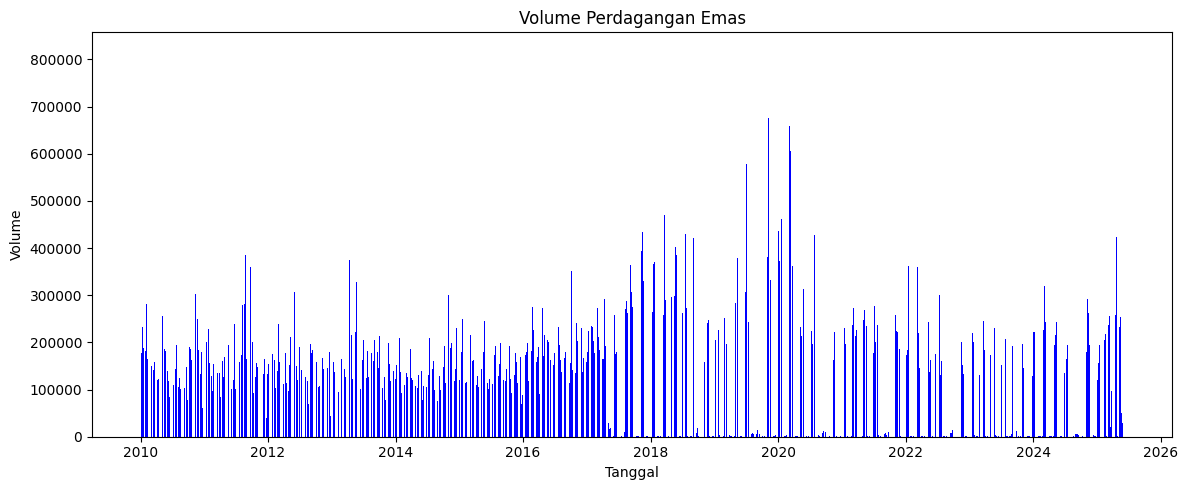

In [ ]:
# Volume perdagangan emas
plt.figure(figsize=(12, 5))
plt.bar(df['Date'], df['Volume'], color='blue')
plt.title('Volume Perdagangan Emas')
plt.xlabel('Tanggal')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()

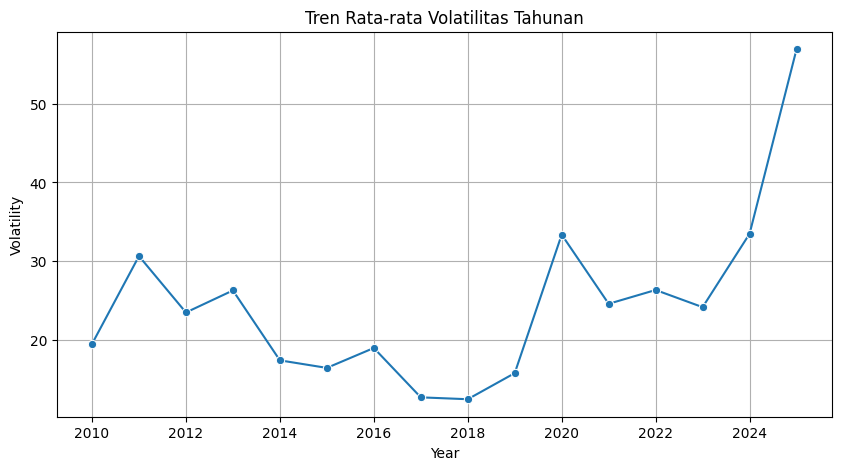

In [ ]:
df['Year'] = df['Date'].dt.year
vol_trend = df.groupby("Year")["Volatility"].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=vol_trend, x="Year", y="Volatility", marker="o")
plt.title("Tren Rata-rata Volatilitas Tahunan")
plt.grid(True)
plt.show()

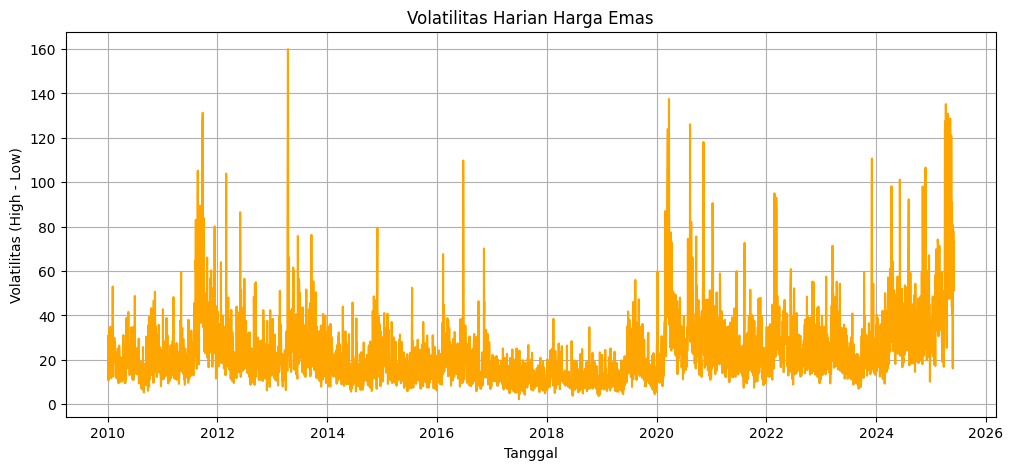

In [ ]:
# Volatilitas harian harga emas
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Volatility'], color='Orange')
plt.title("Volatilitas Harian Harga Emas")
plt.xlabel("Tanggal")
plt.ylabel("Volatilitas (High - Low)")
plt.grid(True)
plt.show()

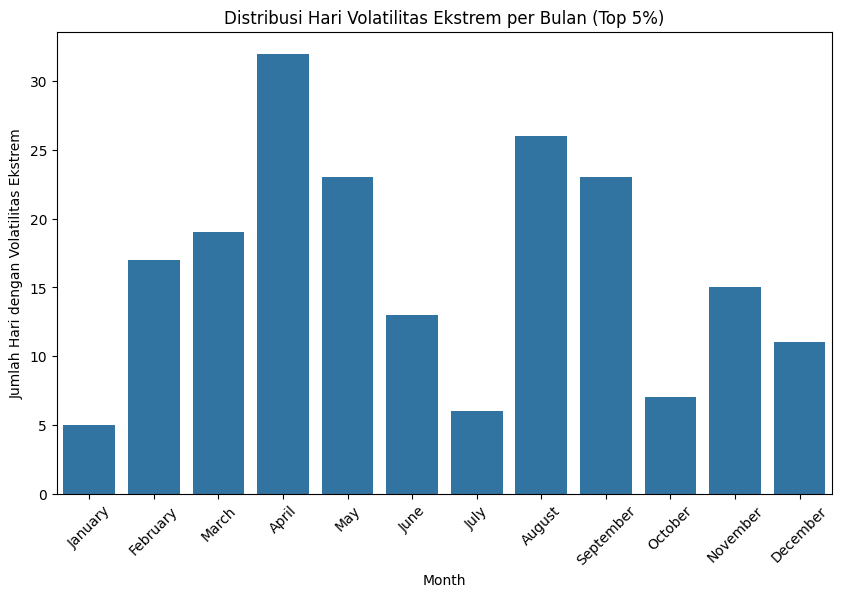

In [ ]:
df['Month'] = df['Date'].dt.month_name()
threshold = df["Volatility"].quantile(0.95)
extreme_days = df[df["Volatility"] > threshold]
extreme_counts = extreme_days["Month"].value_counts().reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

plt.figure(figsize=(10, 6))
sns.barplot(x=extreme_counts.index, y=extreme_counts.values)
plt.xticks(rotation=45)
plt.ylabel("Jumlah Hari dengan Volatilitas Ekstrem")
plt.title("Distribusi Hari Volatilitas Ekstrem per Bulan (Top 5%)")
plt.show()

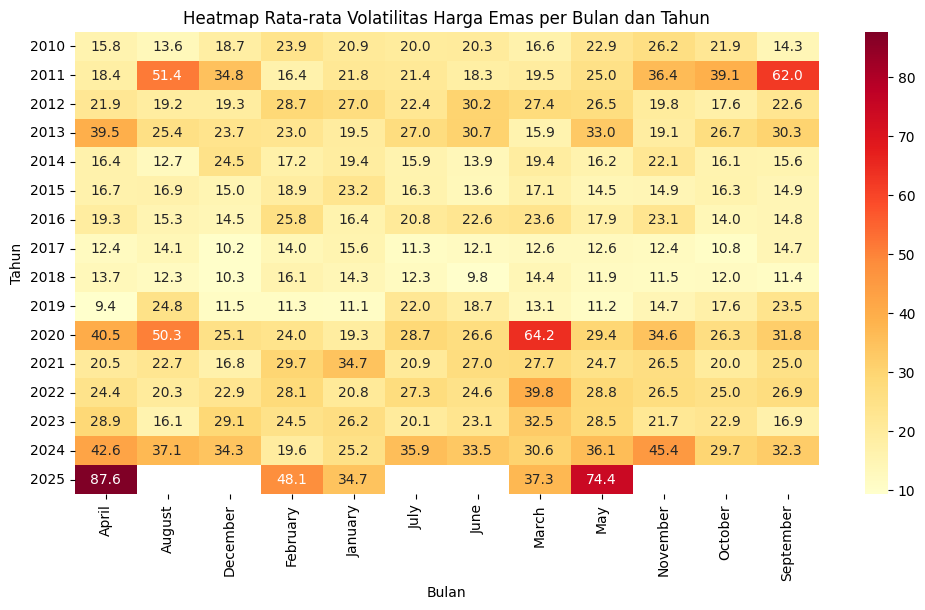

In [ ]:
monthly_avg = df.groupby(['Year', 'Month'])['Volatility'].mean().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_avg, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title('Heatmap Rata-rata Volatilitas Harga Emas per Bulan dan Tahun')
plt.xlabel('Bulan')
plt.ylabel('Tahun')
plt.show()

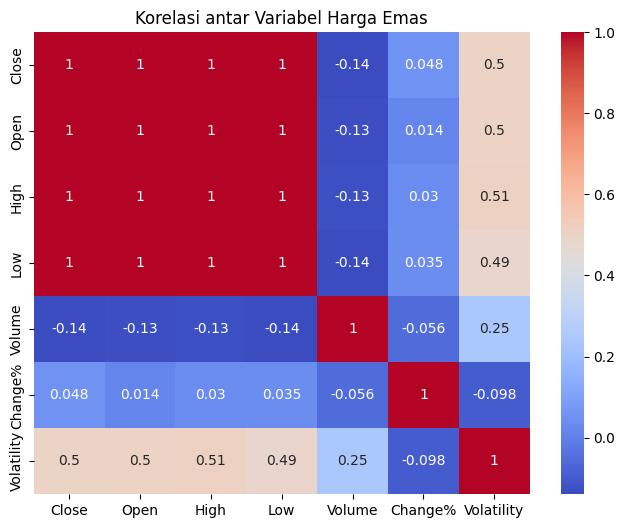

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Close', 'Open', 'High', 'Low', 'Volume', 'Change%', 'Volatility']].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar Variabel Harga Emas")
plt.show()

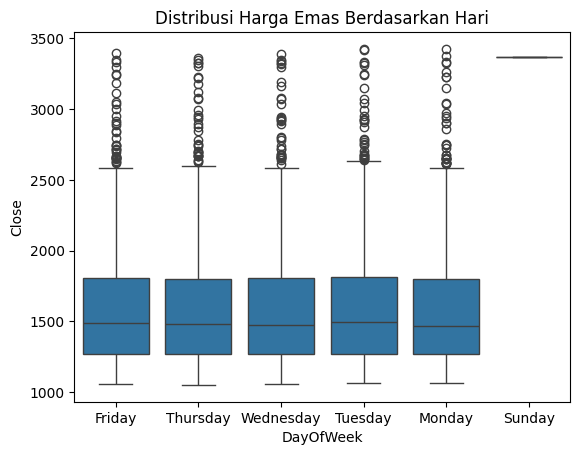

In [ ]:
df['DayOfWeek'] = df['Date'].dt.day_name()
sns.boxplot(x='DayOfWeek', y='Close', data=df)
plt.title("Distribusi Harga Emas Berdasarkan Hari")
plt.show()

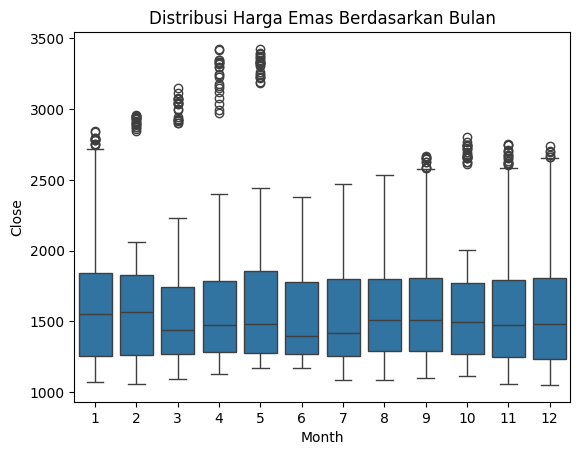

In [ ]:
df['Month'] = df['Date'].dt.month
sns.boxplot(x='Month', y='Close', data=df)
plt.title("Distribusi Harga Emas Berdasarkan Bulan")
plt.show()

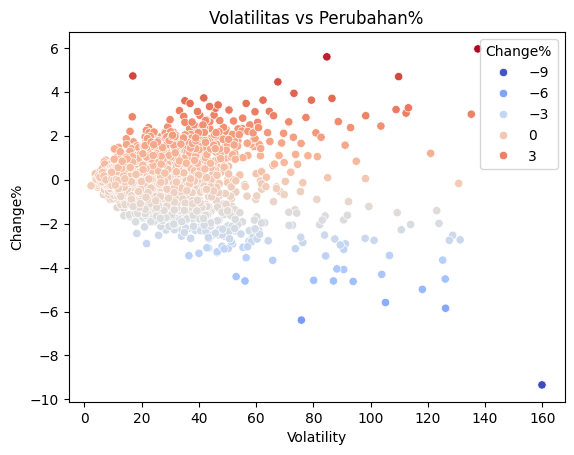

In [ ]:
sns.scatterplot(data=df, x='Volatility', y='Change%', hue='Change%', palette='coolwarm')
plt.title("Volatilitas vs Perubahan%")
plt.show()

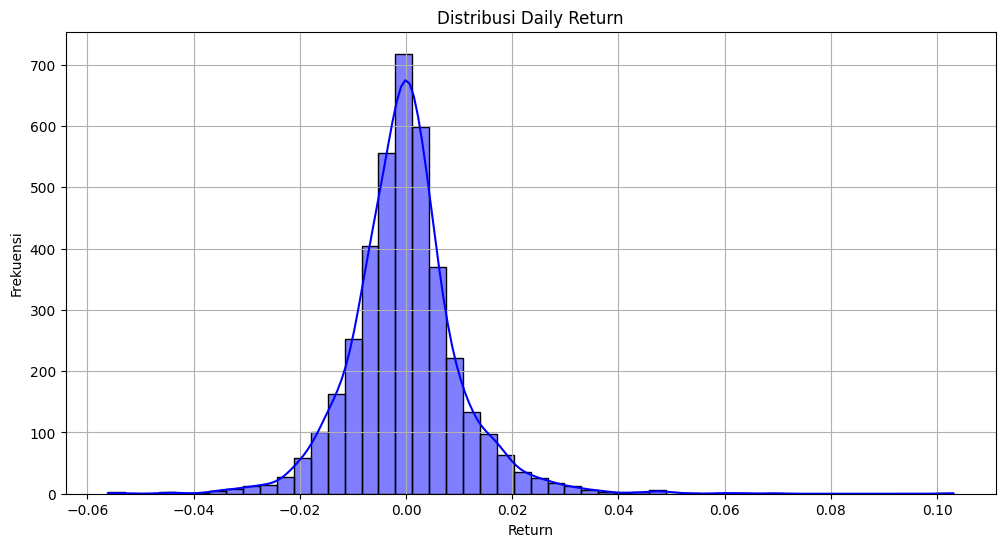

In [ ]:
df['Daily Return'] = df['Close'].pct_change()

plt.figure(figsize=(12,6))
sns.histplot(df['Daily Return'].dropna(), bins=50, kde=True, color='blue')
plt.title("Distribusi Daily Return")
plt.xlabel("Return")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()


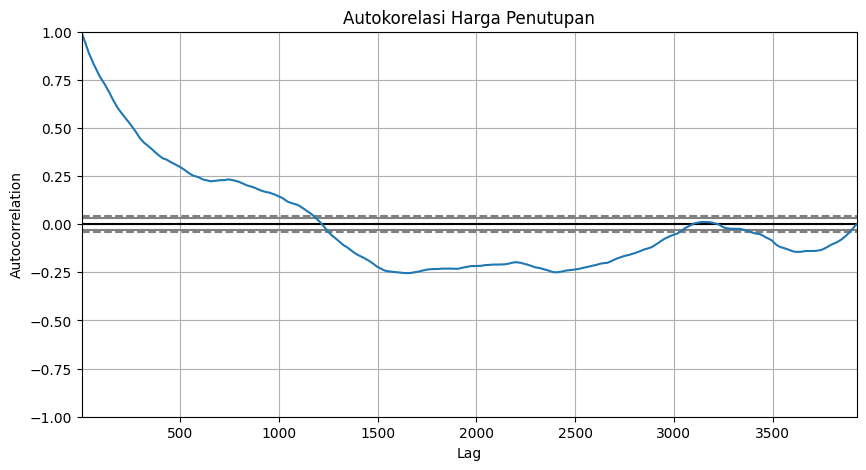

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,5))
autocorrelation_plot(df['Close'].dropna())
plt.title("Autokorelasi Harga Penutupan")
plt.show()

In [ ]:
!pip install plotly --quiet
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
                x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.update_layout(title='Candlestick Chart Harga Emas')
fig.show()

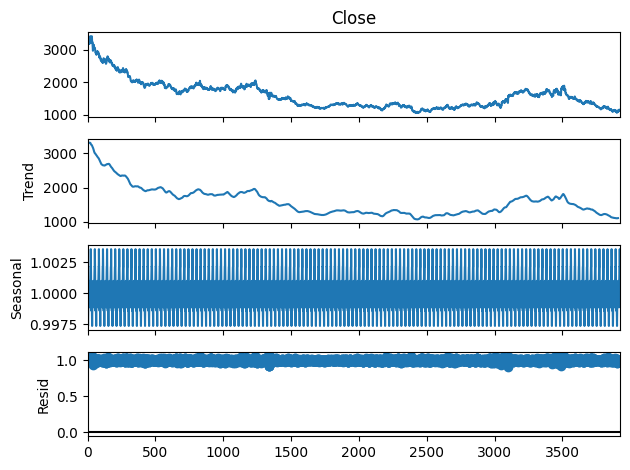

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
result.plot()
plt.show()

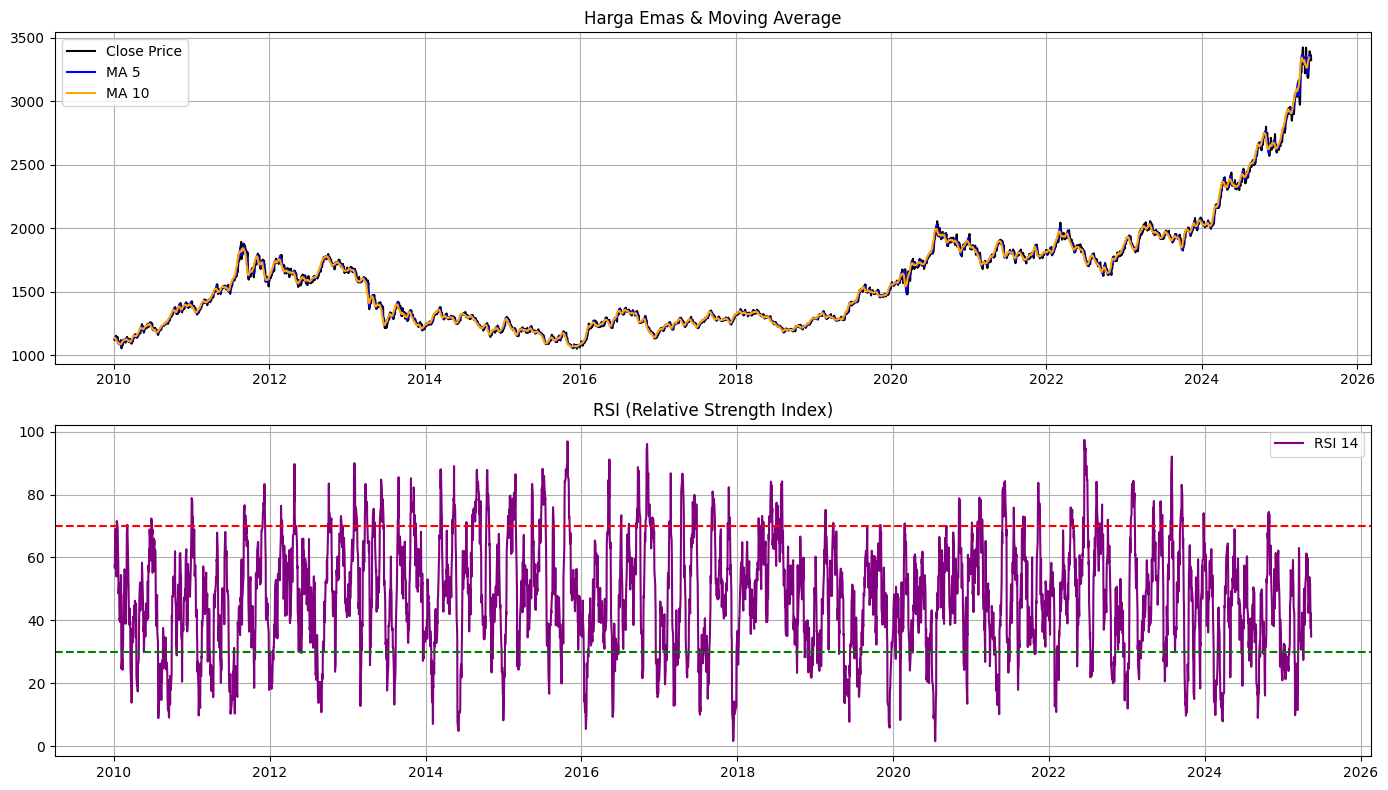

In [ ]:
# Moving Average
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI_14'] = compute_RSI(df['Close'], window=14)

plt.figure(figsize=(14,8))

# Harga dan MA
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Close'], label='Close Price', color='black')
plt.plot(df['Date'], df['MA_5'], label='MA 5', color='blue')
plt.plot(df['Date'], df['MA_10'], label='MA 10', color='orange')
plt.title('Harga Emas & Moving Average')
plt.legend()
plt.grid(True)

# RSI
plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI (Relative Strength Index)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# **RNN dan LSTM**

In [ ]:
# Fitur dan target
features = ['Open', 'High', 'Low']
target = 'Close'

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [ ]:
# Fungsi membuat sequence
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=7)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [ ]:
# RNN Manual
class ManualRNN(Layer):
    def __init__(self, units):
        super(ManualRNN, self).__init__()
        self.units = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.Wx = self.add_weight(shape=(input_dim, self.units),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.Wh = self.add_weight(shape=(self.units, self.units),
                                  initializer='orthogonal',
                                  trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = inputs.shape[1]

        h = tf.zeros((batch_size, self.units))

        for t in range(time_steps):
            x_t = inputs[:, t, :]  # shape (batch, input_dim)

            # Manual dot product input x Wx
            x_contrib = tf.stack([
                tf.reduce_sum(x_t * self.Wx[:, i], axis=1) for i in range(self.units)
            ], axis=1)

            # Manual dot product h x Wh
            h_contrib = tf.stack([
                tf.reduce_sum(h * self.Wh[:, i], axis=1) for i in range(self.units)
            ], axis=1)

            h = tf.tanh(x_contrib + h_contrib + self.b)

        return h

class RNNModel(Model):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = ManualRNN(64)
        self.dropout = Dropout(0.1)
        self.dense = Dense(1)

    def call(self, inputs, training=False):
        x = self.rnn(inputs)
        x = self.dropout(x, training=training)
        return self.dense(x)

# ==== Compile & Train ====
model_manual = RNNModel()
model_manual.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_manual = model_manual.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 116s 81ms/step - loss: 0.0459 - val_loss: 1.1352e-04
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0013 - val_loss: 6.7027e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0012 - val_loss: 1.0047e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 6.0407e-04 - val_loss: 3.8592e-04
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 5.3287e-04 - val_loss: 1.2991e-04
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 4.2441e-04 - val_loss: 6.2616e-05
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 3.6065e-04 - val_loss: 5.4875e-05
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 3.4391e-04 - val_loss: 7.0383e-05
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 2.6717e-04 - val_loss: 5.8166e-05
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 2.9683e-04 - val_loss: 6.9092e-05
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s

25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step
Manual RNN MSE  : 39.5599
Manual RNN RMSE : 6.2897
Manual RNN MAE  : 4.2498
Manual RNN MAPE : 0.28%
Manual RNN R2   : 0.9992


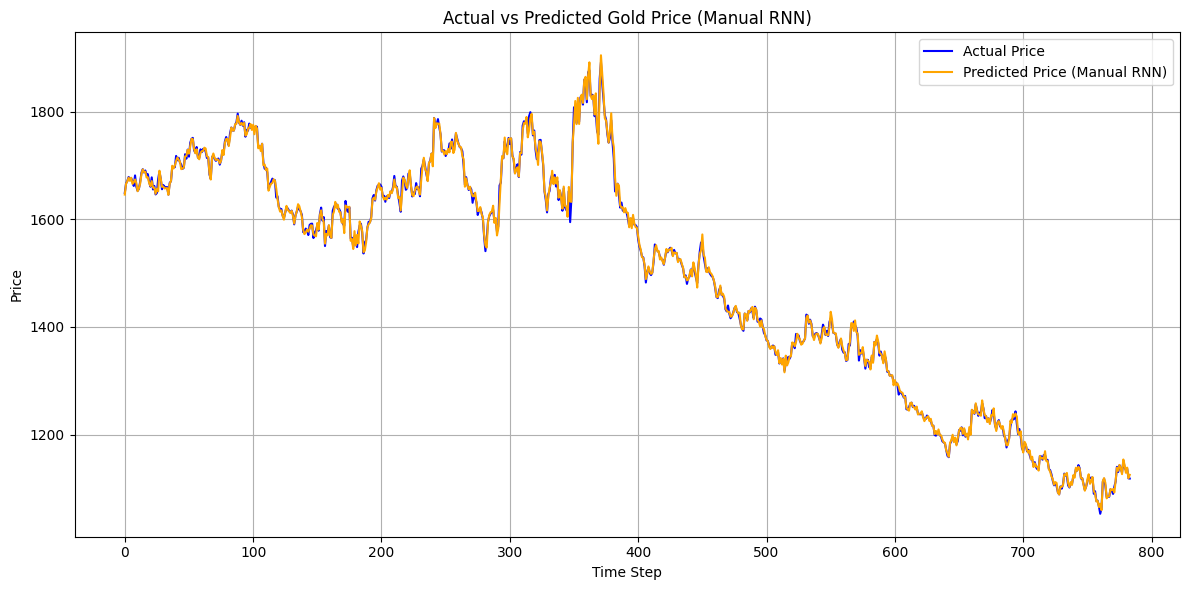

In [ ]:
# Prediksi
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_scaled_manual = model_manual.predict(X_test)
y_pred_inv_manual = scaler_y.inverse_transform(y_pred_scaled_manual)

# Evaluasi
mse_manual = mean_squared_error(y_test_inv, y_pred_inv_manual)
mae_manual = mean_absolute_error(y_test_inv, y_pred_inv_manual)
r2_manual = r2_score(y_test_inv, y_pred_inv_manual)
rmse_manual = np.sqrt(mse_manual)
mape_manual = np.mean(np.abs((y_test_inv - y_pred_inv_manual) / y_test_inv)) * 100

# Cek hasil evaluasi
print(f"Manual RNN MSE  : {mse_manual:.4f}")
print(f"Manual RNN RMSE : {rmse_manual:.4f}")
print(f"Manual RNN MAE  : {mae_manual:.4f}")
print(f"Manual RNN MAPE : {mape_manual:.2f}%")
print(f"Manual RNN R2   : {r2_manual:.4f}")

# Visualisasi
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(y_pred_inv_manual, label='Predicted Price (Manual RNN)', color='orange')
plt.title('Actual vs Predicted Gold Price (Manual RNN)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# LSTM Manual
class ManualLSTM(Layer):
    def __init__(self, units, **kwargs):
        super(ManualLSTM, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W_f = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', trainable=True)
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', trainable=True)
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

        self.W_i = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', trainable=True)
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', trainable=True)
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

        self.W_c = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', trainable=True)
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', trainable=True)
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

        self.W_o = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', trainable=True)
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', trainable=True)
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))

        for t in range(inputs.shape[1]):
            x_t = inputs[:, t, :]

            f = tf.sigmoid(tf.matmul(x_t, self.W_f) + tf.matmul(h, self.U_f) + self.b_f)
            i = tf.sigmoid(tf.matmul(x_t, self.W_i) + tf.matmul(h, self.U_i) + self.b_i)
            o = tf.sigmoid(tf.matmul(x_t, self.W_o) + tf.matmul(h, self.U_o) + self.b_o)
            c_tilde = tf.tanh(tf.matmul(x_t, self.W_c) + tf.matmul(h, self.U_c) + self.b_c)

            c = f * c + i * c_tilde
            h = o * tf.tanh(c)

        return h

# Training model LSTM manual
model_manual_lstm = Sequential([
    ManualLSTM(64),
    Dropout(0.1),
    Dense(1)
])

model_manual_lstm.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_manual_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0167 - val_loss: 2.4555e-04
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1642e-04 - val_loss: 1.6123e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3606e-04 - val_loss: 1.1349e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0216e-04 - val_loss: 9.1212e-05
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6654e-04 - val_loss: 1.2012e-04
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1655e-04 - val_loss: 1.2528e-04
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9997e-04 - val_loss: 7.0683e-05
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7390e-04 - val_loss: 1.0755e-04
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.3517e-04 - val_loss: 6.6036e-05
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2623e-04 - val_loss: 1.0030e-04
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

In [ ]:
# Simpan model
model_manual_lstm.save("manual_model_lstm.keras")

# Simpan scaler
import joblib
joblib.dump(scaler_X, "scaler_x.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[Manual LSTM] MSE   : 35.7305
[Manual LSTM] RMSE  : 5.9775
[Manual LSTM] MAE   : 3.9639
[Manual LSTM] MAPE  : 0.26%
[Manual LSTM] R2    : 0.9992


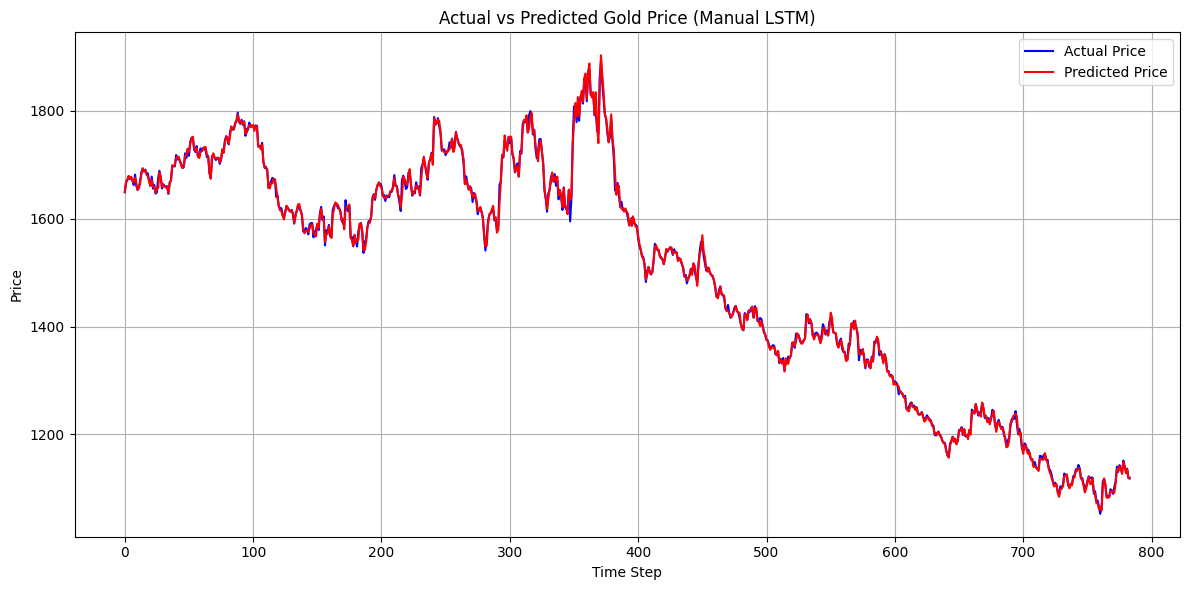

In [ ]:
# Prediksi
y_pred_scaled = model_manual_lstm.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

# Evaluasi
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

# Cetak hasil evaluasi
print(f"[Manual LSTM] MSE   : {mse:.4f}")
print(f"[Manual LSTM] RMSE  : {rmse:.4f}")
print(f"[Manual LSTM] MAE   : {mae:.4f}")
print(f"[Manual LSTM] MAPE  : {mape:.2f}%")
print(f"[Manual LSTM] R2    : {r2:.4f}")

# Visualisasi
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(y_pred_inv, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Gold Price (Manual LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

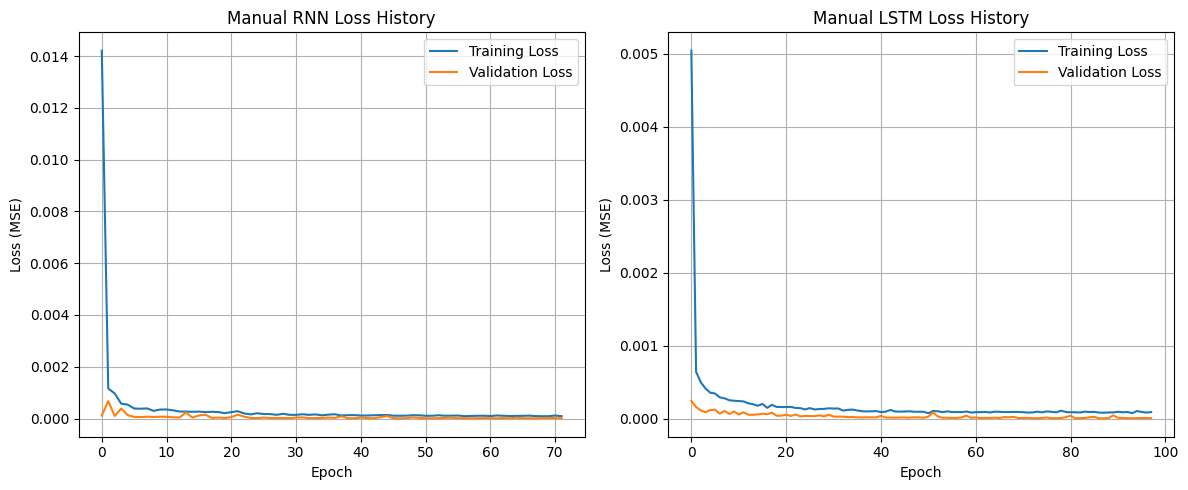

In [ ]:
# Visualisasi history loss dari kedua model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_manual.history['loss'], label='Training Loss')
plt.plot(history_manual.history['val_loss'], label='Validation Loss')
plt.title('Manual RNN Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Manual LSTM Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

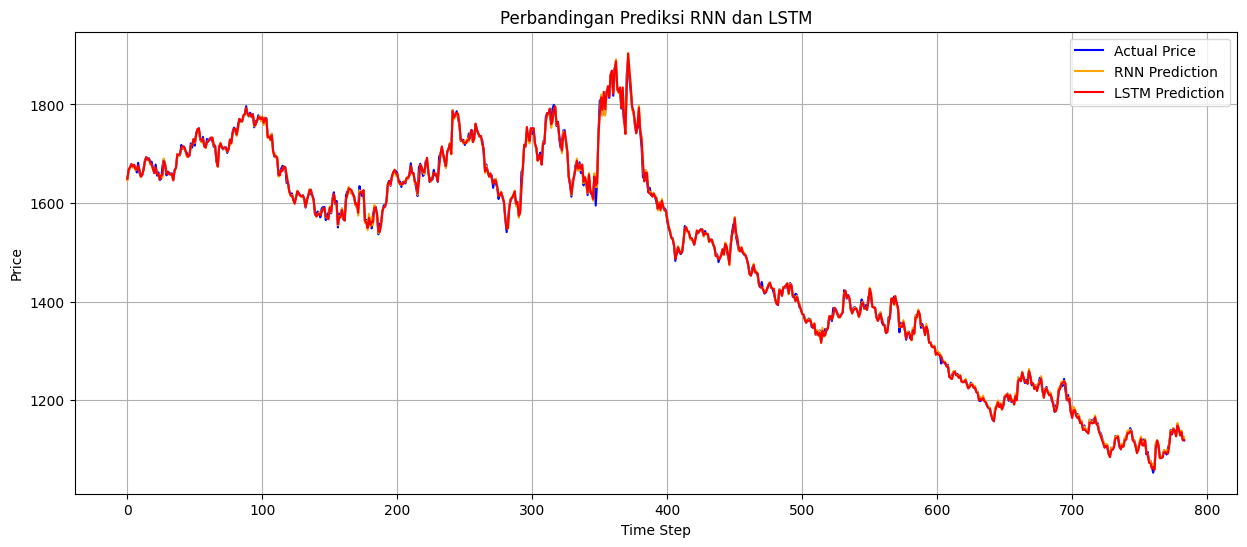

In [ ]:
# Plot perbandingan prediksi RNN dan LSTM
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(y_pred_inv_manual, label='RNN Prediction', color='orange')
plt.plot(y_pred_inv, label='LSTM Prediction', color='red')
plt.title('Perbandingan Prediksi RNN dan LSTM')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

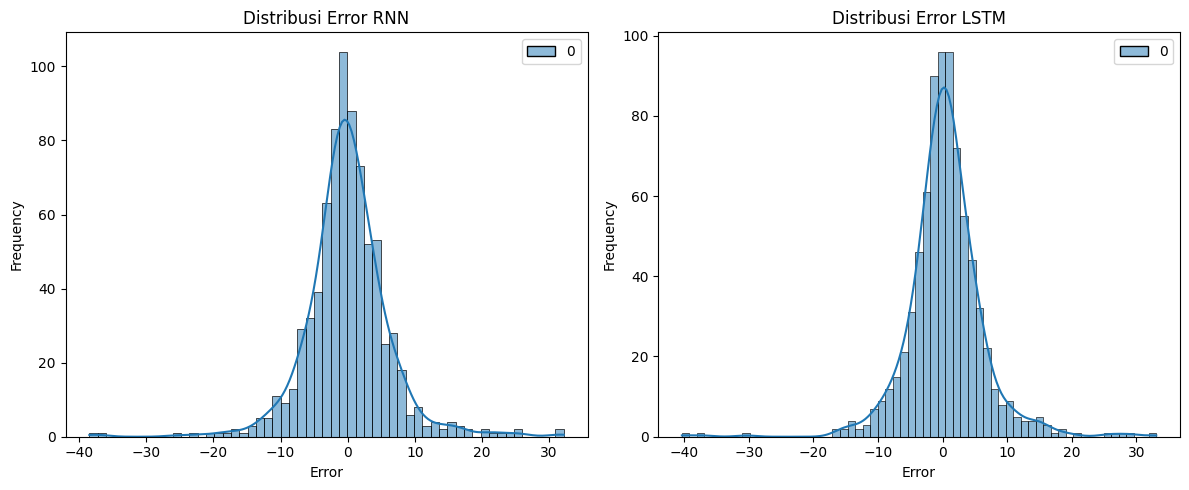

In [ ]:
# Analisis distribusi error
rnn_errors = y_test_inv - y_pred_inv_manual
lstm_errors = y_test_inv - y_pred_inv

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(rnn_errors, kde=True, color='orange')
plt.title('Distribusi Error RNN')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(lstm_errors, kde=True, color='red')
plt.title('Distribusi Error LSTM')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

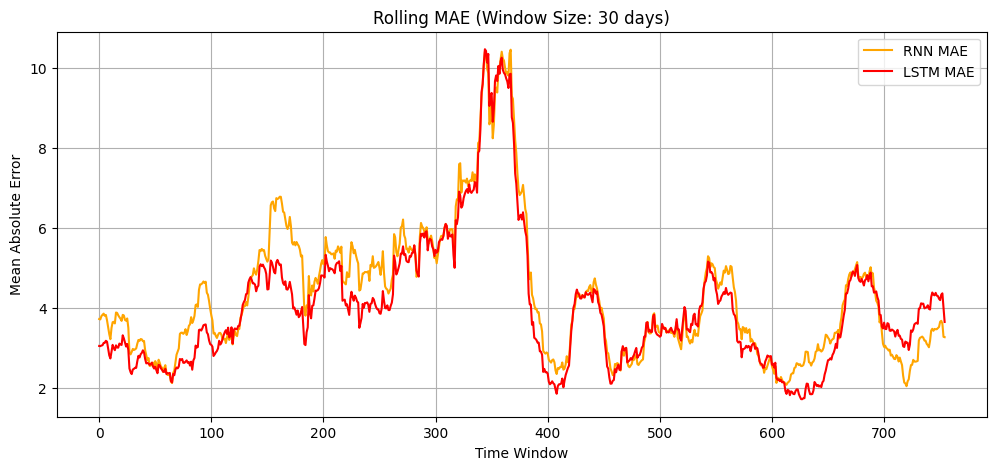


Summary Statistics of Errors:

RNN Error Statistics:
count    784.000000
mean      -0.015284
std        6.293664
min      -38.473560
25%       -2.969452
50%       -0.162671
75%        2.824994
max       32.190454
dtype: float64

LSTM Error Statistics:
count    784.000000
mean       0.460047
std        5.963578
min      -40.380176
25%       -2.276306
50%        0.331763
75%        3.148816
max       33.091821
dtype: float64


In [ ]:
# Analisis performa per periode
window_size = 30  # analisis per 30 hari

def calculate_rolling_metrics(y_true, y_pred, window):
    errors = np.abs(y_true - y_pred)
    rolling_mae = [np.mean(errors[i:i+window]) for i in range(0, len(errors)-window+1)]
    return rolling_mae

rolling_mae_rnn = calculate_rolling_metrics(y_test_inv, y_pred_inv_manual, window_size)
rolling_mae_lstm = calculate_rolling_metrics(y_test_inv, y_pred_inv, window_size)

plt.figure(figsize=(12, 5))
plt.plot(rolling_mae_rnn, label='RNN MAE', color='orange')
plt.plot(rolling_mae_lstm, label='LSTM MAE', color='red')
plt.title(f'Rolling MAE (Window Size: {window_size} days)')
plt.xlabel('Time Window')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
print("\nSummary Statistics of Errors:")
print("\nRNN Error Statistics:")
print(pd.Series(rnn_errors.flatten()).describe())
print("\nLSTM Error Statistics:")
print(pd.Series(lstm_errors.flatten()).describe())

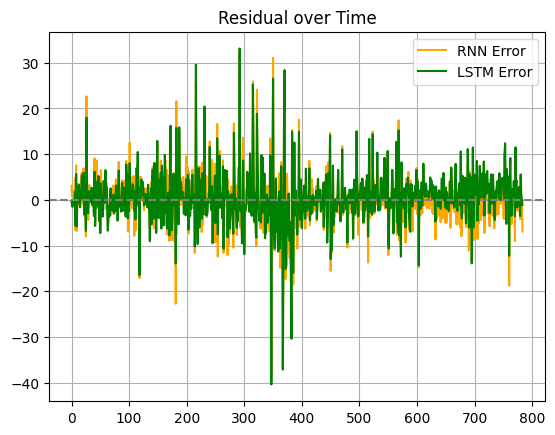

In [ ]:
plt.plot(rnn_errors, label='RNN Error', color='orange')
plt.plot(lstm_errors, label='LSTM Error', color='green')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residual over Time')
plt.legend()
plt.grid(True)
plt.show()


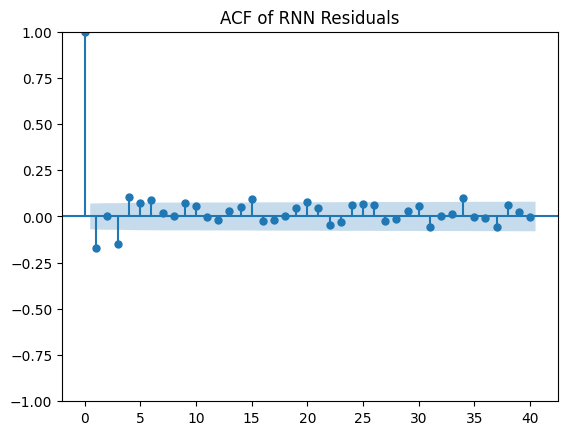

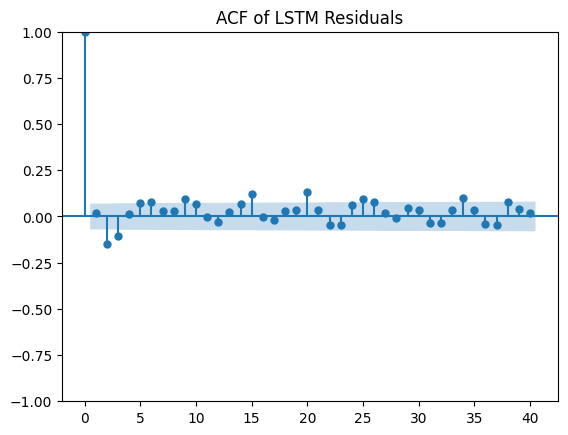

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(rnn_errors.flatten(), lags=40)
plt.title("ACF of RNN Residuals")
plt.show()

plot_acf(lstm_errors.flatten(), lags=40)
plt.title("ACF of LSTM Residuals")
plt.show()


In [ ]:
df

,Date,Close,Open,High,Low,Volume,Change%,Volatility,Year,Month,DayOfWeek,Daily Return,MA_5,MA_10,RSI_14
0,2025-05-30,3330.10,3354.60,3361.4,3310.0,190.0,-0.85,51.4,2025,5,Friday,NaN,NaN,NaN,NaN
1,2025-05-29,3358.70,3328.60,3368.1,3290.0,320.0,1.09,78.1,2025,5,Thursday,0.008588,NaN,NaN,NaN
2,2025-05-28,3322.40,3328.60,3352.0,3301.0,184890.0,-0.18,51.0,2025,5,Wednesday,-0.010808,NaN,NaN,NaN
3,2025-05-27,3328.30,3385.00,3385.0,3311.4,132780.0,-1.37,73.6,2025,5,Tuesday,0.001776,NaN,NaN,NaN
4,2025-05-26,3374.47,3370.17,3384.0,3352.5,29790.0,0.12,31.5,2025,5,Monday,0.013872,3342.794,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,2010-01-08,1138.90,1131.50,1140.0,1119.5,212620.0,0.46,20.5,2010,1,Friday,-0.010856,1139.900,1127.55,69.118668
3922,2010-01-07,1133.70,1139.00,1139.5,1128.7,121150.0,-0.25,10.8,2010,1,Thursday,-0.004566,1138.040,1131.95,66.486851
3923,2010-01-06,1136.50,1118.50,1141.0,1116.8,176900.0,1.59,24.2,2010,1,Wednesday,0.002470,1137.980,1135.28,67.241379
3924,2010-01-05,1118.70,1122.00,1129.6,1115.5,156410.0,0.04,14.1,2010,1,Tuesday,-0.015662,1135.840,1135.89,56.589147


In [ ]:
# Load scaler
scaler_X = joblib.load("scaler_x.pkl")
scaler_y = joblib.load("scaler_y.pkl")

# Load model
from tensorflow.keras.models import load_model
model_manual_lstm_loaded = load_model(
    "manual_model_lstm.keras",
    custom_objects={"ManualLSTM": ManualLSTM}
)

In [ ]:
def predict_future_price(df, model, scaler_X, scaler_y, future_date_str, time_steps=7):
    try:
        df = df.sort_values("Date").reset_index(drop=True)
        last_date = df["Date"].iloc[-1]
        future_date = pd.to_datetime(future_date_str)

        if future_date <= last_date:
            return f"Tanggal {future_date_str} sudah ada dalam data."

        # Hitung berapa hari ke depan dari data terakhir
        delta_days = (future_date - last_date).days
        if delta_days <= 0:
            return f"Tanggal tidak valid."

        # Ambil 7 hari terakhir untuk input awal
        past_window = df[['Open', 'High', 'Low']].iloc[-time_steps:].values
        scaled_window = scaler_X.transform(pd.DataFrame(past_window, columns=['Open', 'High', 'Low']))

        # Prediksi berulang (multi-step)
        for _ in range(delta_days):
            input_seq = np.expand_dims(scaled_window, axis=0)
            pred_scaled = model.predict(input_seq)
            pred = scaler_y.inverse_transform(pred_scaled)[0][0]

            # Gunakan prediksi untuk update window: asumsikan open/high/low sama dengan prediksi
            next_input = np.array([[pred, pred, pred]])
            next_input_scaled = scaler_X.transform(pd.DataFrame(next_input, columns=['Open', 'High', 'Low']))
            scaled_window = np.vstack([scaled_window[1:], next_input_scaled])

        return f"Prediksi harga emas pada {future_date_str}: {pred:.2f}"

    except Exception as e:
        return f"Terjadi error: {e}"

In [ ]:
user_input = input("Masukkan tanggal (YYYY-MM-DD): ")
hasil = predict_future_price(df, model_manual_lstm_loaded, scaler_X, scaler_y, user_input)
print(hasil)

Masukkan tanggal (YYYY-MM-DD): 2025-06-12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediksi harga emas pada 2025-06-12: 3174.86
